In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-21 22:46:54.956059: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-21 22:46:55.059445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-21 22:46:55.059484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-21 22:46:55.073341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-21 22:46:55.103973: I tensorflow/core/platform/cpu_feature_guar

# inference: kmax=0.4 (for p & b) - with noise - orig (no reparam)

In [18]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'
tag_reparam = ''

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '', '']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [19]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [20]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


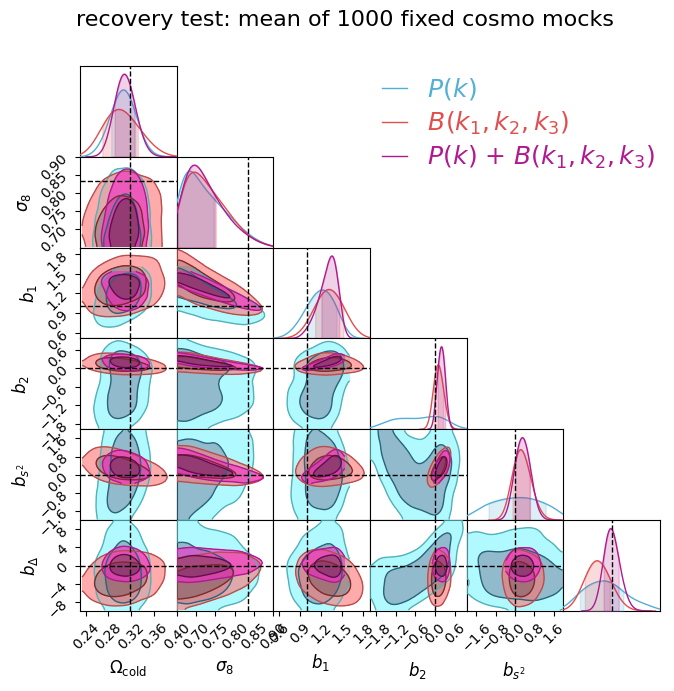

In [21]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
#param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
#param_names_contour = ['omega_cold', 'sigma8_cold', 'b1']
#param_names_contour = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

# inference: kmax=0.4 (for p & b) - with noise - reparam

In [2]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'
tag_reparam = '_rp'

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '', '']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [3]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [4]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


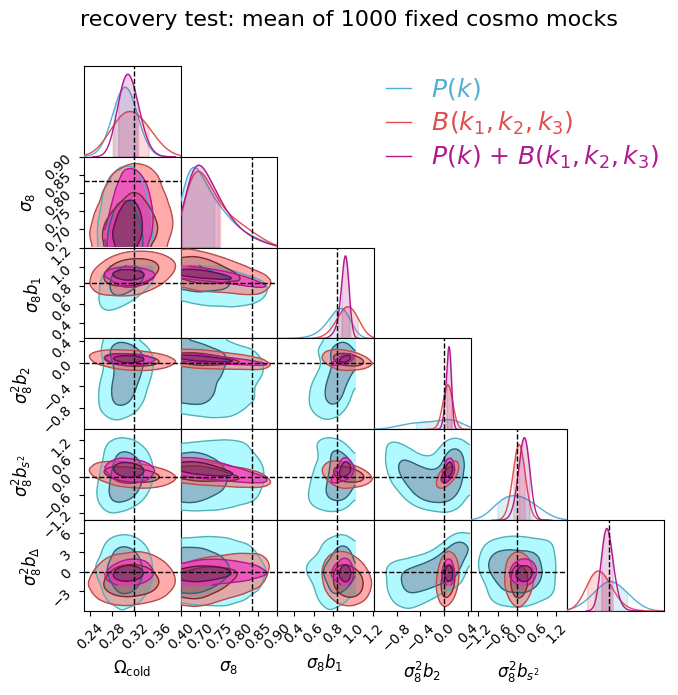

In [17]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
#param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
#param_names_contour = ['omega_cold', 'sigma8_cold', 'b1']
#param_names_contour = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


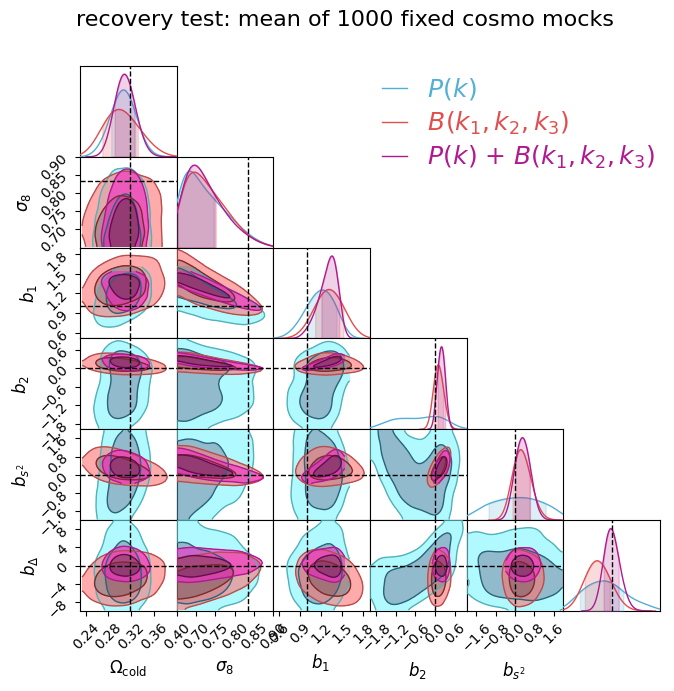

In [22]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
#param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
#param_names_contour = ['omega_cold', 'sigma8_cold', 'b1']
#param_names_contour = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents, unreparameterize=True)

# inference: kmax=0.4 (for p & b) - noiseless - orig (no reparam)

In [1]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

NameError: name 'utils' is not defined

In [ ]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [2]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = None
tag_Anoise_fixed = None
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

NameError: name 'data_loader' is not defined

In [3]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
if tag_noise_fixed is None:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + '_mean' for tag_stats in tag_stats_arr]
else:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

NameError: name 'param_names_vary' is not defined

# inference: kmax=0.4 (for p & b) - noiseless - reparam

In [4]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None
tag_reparam = '_rp'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

NameError: name 'utils' is not defined

In [5]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

NameError: name 'data_loader' is not defined

### Inference results: cosmic variance / fixed cosmo (quijote)

In [6]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = None
tag_Anoise_fixed = None
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

NameError: name 'data_loader' is not defined

In [7]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
if tag_noise_fixed is None:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + '_mean' for tag_stats in tag_stats_arr]
else:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

NameError: name 'param_names_vary' is not defined